# 初期設定

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from control import matlab

# 原理
## 振り子をつかった地面振動の計測
<img src="Pendulum.png" width=500>

図１：振り子(左)とその伝達関数（右）

振り子で鏡を吊るせば、共振周波数以上で鏡は防振されるので、地面と鏡の相対変位を読み取れば、地面振動がわかる。

地面振動$x_0$から鏡の変位$x$までの伝達関数$H_0$は、
$$
\frac{x}{x_0}=P_0 = \frac{\frac{\omega_0}{Q}{s}+\omega_0}{s^2+\frac{\omega_0}{Q}{s}+\omega_0}
$$
である。（図１右の黒線）

相対変位 $d$ は、共振周波数以上では地面振動 $x_0$ に近づく。鏡が十分に防振されるからである。一方で、共振周波数以下では防振されなくなるので、鏡と地面は同じ動きをしてしまい、地面振動を測ることができない。より低周波の地面振動を測るならば、より低周波に共振をもつ地震計が必要になると言える。

さて、我々は干渉計をつかって振り子と地面の相対変位を測るわけだが、干渉計は線形領域が狭いため、ダイナミックレンジが小さいのが難点である。
それを解決するたに、フィードバック制御をして線形領域にフリンジが維持できるように工夫をする。

## 制御信号をつかって地面振動を求める

<img src="BlockDiagram.png" width=420>

図2：ブロック図。Aはアクチュエータ効率、Pは振り子の伝達関数、Dは干渉計の応答係数、Cは制御フィルター。

ブロック図によれば、フィードバック信号は
$$
f = \frac{G}{1+G}r + \frac{G}{1+G} \frac{x_0}{A}
$$
のように表すことができる。

ところで、入力信号はDC電圧であり、我々は地面振動のDC成分は興味ないので、rの寄与は無視すると、地面振動$x_0$は、
$$
x_0 = \frac{1+G}{G} Af
$$
となる。

# 計算

フィードバック信号から地面振動を求めるために、Aを求めなければならない。

振り子の伝達関数 P と干渉計の応答 D はあらかじめ計算で求めることができるので、制御が十分安定に働くようなフィルター C を入れた状態でGを測定すれば、残りのアクチュエータ効率 A を求めることができる。

（アクチュエータ効率を直接求める方法を考えてみるとおもしろいかも。）

## Dを求める
ミッドフリンジにロックした干渉計の応答係数 D は、
$$
D = \frac{(V_{max}-V_{min})}{2}\frac{4\pi}{\lambda}
$$
で計算することができる。

In [2]:
nm = 1e-9
Vmax = 1.4 # [V]
Vmin = 0.2 # [V]
contrast = (Vmax-Vmin)/(Vmax+Vmin) # []
laser_lambda = 1000.0*nm # [m]
D = (Vmax-Vmin)/2.0 * (4.0*np.pi/laser_lambda) # [V/m]
print "D : {0:3.2e} [V/m]".format(D)

D : 7.54e+06 [V/m]


## Cを求める

カットオフ周波数$3\, Hz$でゲインが200倍のローパスフィルターで制御したので、これらパラメータで伝達関数を計算で求める。

Gain : 200.0
f0 : 3.0 [Hz]


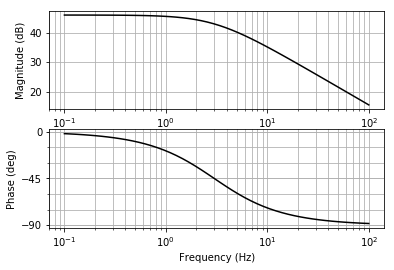

In [3]:
from control import matlab
gain = 200.0
f0 = 3.0
w0 = f0*2.0*np.pi # [rad]
num = [w0*gain] 
dem = [1,w0] 
C = matlab.tf(num,dem)
mag, phase, omega =matlab.bode(C,Plot=True,color='k')

print "Gain : {0}".format(gain)
print "f0 : {0} [Hz]".format(f0)

## Pを求める
振り子は、測定していないのでなんとも言えないが、もっともらしい値を仮定した。

振り子のパラメータ
Q : 2
f0 : 1.3 [Hz]


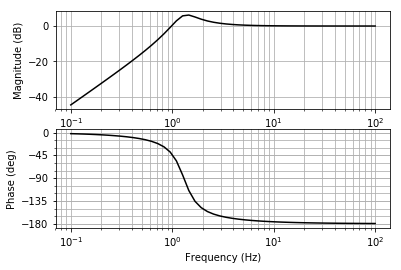

In [4]:
from control import matlab
Q = 2 # []
f0 = 1.3 # [Hz]
w0 = f0*2.0*np.pi # [rad]
num = [-1,0,0] 
dem = [1.0,w0/Q,w0**2] 
P = matlab.tf(num,dem)
mag, phase, omega =matlab.bode(P,Plot=True,color='k')
print "振り子のパラメータ"
print "Q : {0}".format(Q)
print "f0 : {0} [Hz]".format(f0)

## Gの測定結果からAを求める
実測に合うようにAを調整してみた。

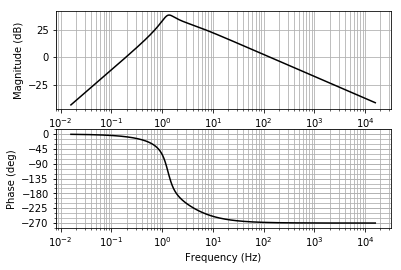

In [5]:
A=3.0e-8 # [m/V]
G= D*C*P*A
mag, phase, omega =matlab.bode(G,np.logspace(-1,5,1e5),Plot=True,color='k')
phase = ( phase + np.pi) % (2 * np.pi ) - np.pi
phase = np.rad2deg(phase)
mag = 20*np.log10(mag)

In [6]:
data = np.loadtxt('OpenLoop.csv',delimiter=',',comments='%')
f = data[:,0]
tf12_mag = data[:,5] # dB
tf12_phase = data[:,6] # deg 

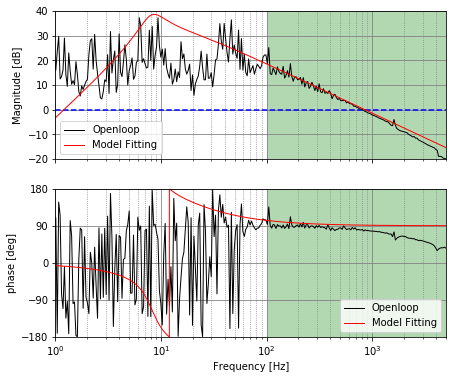

In [7]:
fig, (ax0,ax1) = plt.subplots(2,1,sharex=True, figsize=(7,6))    

# upper graph
ax0.semilogx(f,tf12_mag,'k-',label='Openloop',linewidth=1)
ax0.semilogx(omega,mag,'r-',label='Model Fitting',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1e0,5e3)
ax0.set_ylim(-20,40)
ax0.set_ylabel('Magnitude [dB]')
ax0.legend()    
ax0.hlines([0], 1e0, 5e3, "b", linestyles='--') # 0 dB line
ax0.axvspan(1e2, 7e3, facecolor='g', alpha=0.3)

# lower graph
ax1.semilogx(f,tf12_phase,'k-',label='Openloop',linewidth=1)    
ax1.semilogx(omega,phase,'r-',label='Model Fitting',linewidth=1)    
ax1.grid(b=True, which='major', color='gray', linestyle='-')
ax1.grid(b=True, which='minor', color='gray', linestyle=':')
ax1.set_ylabel('phase [deg]')    
ax1.set_xlim(1e0,5e3)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_yticks(np.arange(-180,181,90))
ax1.set_ylim(-180,180)
ax1.axvspan(1e2, 7e3, facecolor='g', alpha=0.3)
ax1.legend()

アクチュエータ効率 A が 3.0e-8 [m/V] のとき、実測したGと合う。測定できている緑の領域でフィッティングした。

10Hz以下は測れていない。フィルターCのゲインが大きすぎて、十分なエキサイト信号が入れられなかったか？

位相が遅れてそうなきがするけど、見なかったことにする。

# 地面振動を求める
## Closed loop 伝達関数
さて、アクチュエータ効率Aを求めたので、ブロック図のすべての要素が決まった。
したがって、地面振動から制御信号へのClosedLoop伝達関数をつかって、以下のとおり、地面振動を制御信号からもとめてみる。

$$
x_0 = \frac{1+G}{G} Af
$$


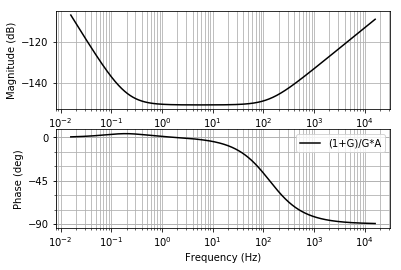

In [8]:
mag, phase, omega =matlab.bode((1+G)/G*A,np.logspace(-1,5,1e5),label='(1+G)/G*A',Plot=True,color='k')
plt.legend()

## フィードバック信号で地面振動をもとめる

1-50Hzあたりで平坦な応答をもっているので、この領域で地面振動をもとめてみた。マゼンダで囲った領域。

それ以外は、応答を描けないといけないのでちょっとcontrolライブラリでは簡単にできない。なので、平坦なところだけ。

レファレンス用の地面振動レベルとして、JGW-G0500217のデータを引用した。$1\times10^{-9}/f^2 \mathrm{[m/rtHz]}$の地面振動。

https://gwdoc.icrr.u-tokyo.ac.jp/cgi-bin/private/DocDB/ShowDocument?docid=217


In [9]:
# Load data from csv file
data = np.loadtxt('FeedBack.csv',delimiter=',',comments='%')
freq = data[:,0]
_ch1 = data[:,1]
_ch2 = data[:,2]

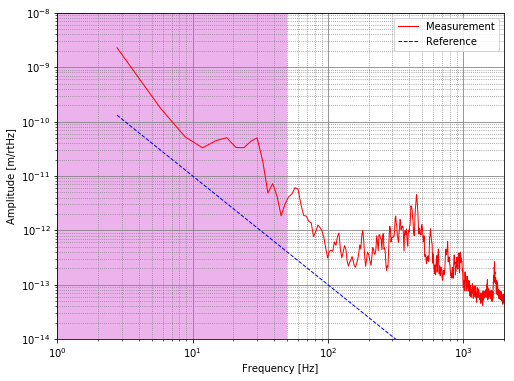

In [10]:
# Plot 
ch1 = _ch1*A#*freq#*(1+G)/G
ch2 = _ch2*A
ref = 1e-9/freq**(2.0)
fig, (ax0) = plt.subplots(1,1,sharex=True,figsize=(8,6))    
ax0.loglog(freq,ch1,'r-',label='Measurement',linewidth=1)
#ax0.loglog(freq,ch2,'k-',label='Not connected',linewidth=1)
ax0.loglog(freq,ref,'b--',label='Reference',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1,2000)
ax0.set_ylim(1e-14,1e-8)
ax0.set_xlabel('Frequency [Hz]')
ax0.set_ylabel('Amplitude [m/rtHz]')
ax0.legend()
ax0.axvspan(1e0, 5e1, facecolor='m', alpha=0.3)


# Pythonチュートリアル

## スペクトル密度のグラフを描いてみる

Moku:LabでとったPSDデータをPythonで読んでグラフを描いてみます。

In [11]:
# Load data from csv file
data = np.loadtxt('FeedBack.csv',delimiter=',',comments='%')
freq = data[:,0]
ch1 = data[:,1]
ch2 = data[:,2]

In [ ]:
# Plot 
fig, (ax0) = plt.subplots(1,1,sharex=True,figsize=(8,6))    
ax0.loglog(freq,ch1,'r-',label='Feedback',linewidth=1)
ax0.loglog(freq,ch2,'k-',label='Not connected',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1,2000)
ax0.set_xlabel('Frequency [Hz]')
ax0.set_ylabel('Amplitude [V/rtHz]')
ax0.legend()

OK。描けた。

## 伝達関数を描いてみる

今度はBode図を描く。

In [ ]:
data = np.loadtxt('OpenLoop.csv',delimiter=',',comments='%')
f = data[:,0]
#ch1_mag = data[:,1] # dB
#ch1_phase = data[:,2] # deg
#ch2_mag = data[:,3] # dB
#ch2_phase = data[:,4] # deg
tf12_mag = data[:,5] # dB
tf12_phase = data[:,6] # deg 

In [ ]:
fig, (ax0,ax1) = plt.subplots(2,1,sharex=True, figsize=(8,6))    

# upper graph
ax0.semilogx(f,tf12_mag,'k-',label='Openloop',linewidth=1)
ax0.grid(b=True, which='major', color='gray', linestyle='-')
ax0.grid(b=True, which='minor', color='gray', linestyle=':')
ax0.set_xlim(1e0,5e3)
ax0.set_ylim(-20,40)
ax0.set_ylabel('Magnitude [dB]')
ax0.legend()    
ax0.hlines([0], 1e0, 5e3, "red", linestyles='--') # 0 dB line

# lower graph
ax1.semilogx(f,tf12_phase,'k-',label='Openloop',linewidth=1)    
ax1.grid(b=True, which='major', color='gray', linestyle='-')
ax1.grid(b=True, which='minor', color='gray', linestyle=':')
ax1.set_ylabel('phase [deg]')    
ax1.set_xlim(1e0,5e3)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_yticks(np.arange(-180,181,90))
ax1.set_ylim(-180,180)
ax1.legend()